In [275]:
import pandas as pd
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import featuretools as ft
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV

trainval = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/train.csv")
test = pd.read_csv("C:/Users/Admin/Desktop/Advanced Analytics/Assignment/Assignment 1/data/test.csv")

extra_params = {"feature_tools" : 0, "undersampling" : 0, "oversampling" : 0, "drop_cat_vars" : 0, "time_column" : 1, "corr_thresh" : 0.9}

## Division of Sets

In [276]:
X_trainval = trainval.drop(columns = "target")
y_trainval = trainval["target"]

In [277]:
train, val, train_target, val_target = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [278]:
train['target'] = train_target
val['target'] = val_target

In [279]:
#Keep average cost min
averagecostmin = val['average cost min']
idtest = test["id"]

## Initial Exploration

In [280]:
train.describe()

,Age,L_O_S,Dropped_Calls,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,...,call_cost_per_min,actual call cost,Total_call_cost,Total_Cost,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,target
count,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,...,4032.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000,4035.000000
mean,31.414126,33.699347,2.673358,238.945229,708.792184,104.036431,311.938372,16.322677,50.079971,169.551549,...,10.081397,19.133955,73.501256,186.803427,0.168306,0.609716,0.327824,0.061717,0.162328,0.146716
std,12.775443,14.007828,3.418703,239.288923,503.929355,97.260823,199.167646,16.296733,36.092455,141.787096,...,2.108023,27.987193,60.000356,82.079489,0.077812,0.224430,0.209932,0.063644,0.105643,0.353867
min,12.000000,9.633333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,59.940000,0.048998,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,21.300000,0.000000,59.000000,307.500000,28.000000,149.550000,4.000000,22.800000,64.261044,...,8.573250,0.000000,32.134081,123.802373,0.134413,0.466317,0.165139,0.020942,0.078918,0.000000
50%,29.000000,33.666667,1.000000,161.000000,614.400001,73.000000,291.000000,11.000000,44.399999,132.279506,...,9.518597,7.515854,57.801016,173.254831,0.154525,0.654877,0.287722,0.043932,0.157734,0.000000
75%,39.000000,45.933333,2.000000,343.000000,1014.300000,156.000000,446.400000,24.000000,71.750000,236.853610,...,11.696253,28.308661,99.217719,232.116107,0.179302,0.782261,0.458395,0.080924,0.244154,0.000000
max,80.000000,58.200000,15.000000,1626.000000,2901.600001,560.000000,1091.099999,106.000000,205.000000,935.947864,...,21.734694,184.892166,437.063835,587.063835,1.357564,1.000000,1.000000,0.731884,2.601223,1.000000


In [281]:
train.describe(include = 'object')

,Gender,Connect_Date,tariff,Handset,Usage_Band,Tariff_OK,high Dropped calls,No Usage,id
count,4035,4035,4035,4035,4032,4035,4035,4035,4035
unique,2,1310,5,11,5,4,2,2,4035
top,F,11/07/1999,CAT 200,S50,Med,OK,F,F,K277140
freq,2042,11,1802,944,2232,4006,3933,4032,1


Drop ID (too many unique values)

In [282]:
train = train.drop(columns = ["id"])
val = val.drop(columns = ["id"])
test = test.drop(columns = ["id"])

## Preprocessing

#### Feature Engineering

In [283]:
if extra_params["time_column"] == 1:
    train["Connect_Date"] = train["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    test["Connect_Date"] = test["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%y"))
    val["Connect_Date"] = val["Connect_Date"].apply(lambda x : datetime.strptime(x, "%d/%m/%Y"))
    
    max_train = train["Connect_Date"].max()
    
    train["End_Date"] = max_train
    test["End_Date"] = max_train
    val["End_Date"] = max_train

    train["Connect_Time"] = train["End_Date"] - train["Connect_Date"]
    test["Connect_Time"] = test["End_Date"] - test["Connect_Date"]
    val["Connect_Time"] = val["End_Date"] - val["Connect_Date"]

    train["Connect_Time"] = train["Connect_Time"].apply(lambda x : x.days)
    test["Connect_Time"] = test["Connect_Time"].apply(lambda x : x.days)
    val["Connect_Time"] = val["Connect_Time"].apply(lambda x : x.days)

    train = train.drop(columns = ["End_Date"])
    test = test.drop(columns = ["End_Date"])
    val = val.drop(columns = ["End_Date"])

train = train.drop(columns = ["Connect_Date"])
test = test.drop(columns = ["Connect_Date"])
val = val.drop(columns = ["Connect_Date"])

#### Missing Values

In [284]:
train.isna().sum()

Gender                    0
Age                       0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       3
Usage_Band                3
Mins_charge               0
call_cost_per_min         3
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls        0
No Usage            

In [285]:
rows_with_missing_values = train[train.isnull().any(axis=1)]

In [286]:
rows_with_missing_values[["call_cost_per_min", "Dropped_calls_ratio", "Usage_Band"]]

,call_cost_per_min,Dropped_calls_ratio,Usage_Band
3836,NaN,NaN,NaN
4301,NaN,NaN,NaN
3237,NaN,NaN,NaN


Missing values are all in the same 3 rows. Since they're only 3 observations out of 4035, they're imputed using median imputation

##### Imputing Numerical Columns

In [287]:
# Assuming 'data' is your dataset with missing values
# Create an instance of SimpleImputer with strategy='median'
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the data
imputer.fit(train[["call_cost_per_min", "Dropped_calls_ratio"]])

# Transform the data by replacing missing values with the median
test_clean = imputer.transform(test[["call_cost_per_min", "Dropped_calls_ratio"]])
train_clean = imputer.transform(train[["call_cost_per_min", "Dropped_calls_ratio"]])
val_clean = imputer.transform(val[["call_cost_per_min", "Dropped_calls_ratio"]])

In [288]:
train["call_cost_per_min"] = train_clean[:, 0]
test["call_cost_per_min"] = test_clean[:, 0]
val["call_cost_per_min"] = val_clean[:, 0]

train["Dropped_calls_ratio"] = train_clean[:, 1]
test["Dropped_calls_ratio"] = test_clean[:, 1]
val["Dropped_calls_ratio"] = val_clean[:, 1]

##### Imputing Categorical Column

In [289]:
# Initialize the imputer with 'most_frequent' strategy
imputer = SimpleImputer(strategy='most_frequent')

imputer.fit(np.array(train["Usage_Band"]).reshape(-1, 1))

train["Usage_Band"] = imputer.transform(np.array(train["Usage_Band"]).reshape(-1, 1))[:, 0]
test["Usage_Band"] = imputer.transform(np.array(test["Usage_Band"]).reshape(-1, 1))[:, 0]
val["Usage_Band"] = imputer.transform(np.array(val["Usage_Band"]).reshape(-1, 1))[:, 0]

#### Variable Selection

##### Dropping numerical variables that are useless

In [290]:
correlation_matrix = train[train.select_dtypes(include=['number']).columns.tolist()].corr()

In [291]:
corrtarget = correlation_matrix['target']

In [292]:
# Make plot for this

In [293]:
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > extra_params["corr_thresh"]:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

In [294]:
high_correlation_pairs

[('L_O_S', 'Connect_Time'),
 ('Peak_calls_Sum', 'National_calls'),
 ('Peak_mins_Sum', 'National mins'),
 ('Peak_mins_Sum', 'All_calls_mins'),
 ('International_mins_Sum', 'Total_call_cost'),
 ('Nat_call_cost_Sum', 'actual call cost'),
 ('National mins', 'All_calls_mins'),
 ('All_calls_mins', 'Total_Cost'),
 ('Total_call_cost', 'Total_Cost'),
 ('Peak ratio', 'OffPeak ratio')]

In [295]:
def build_adjacency_list(pairs):
    adjacency_list = defaultdict(list)
    for u, v in pairs:
        adjacency_list[u].append(v)
        adjacency_list[v].append(u)
    return adjacency_list

# Function to perform depth-first search (DFS) traversal to find connected components
def dfs(node, adjacency_list, visited, component):
    visited.add(node)
    component.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, adjacency_list, visited, component)

# Function to find connected components in the graph
def find_connected_components(pairs):
    adjacency_list = build_adjacency_list(pairs)
    visited = set()
    connected_components = []
    for node in adjacency_list:
        if node not in visited:
            component = []
            dfs(node, adjacency_list, visited, component)
            connected_components.append(component)
    return connected_components

# Find connected groups
connected_groups = find_connected_components(high_correlation_pairs)

In [296]:
def get_variables_to_drop(group, corrtarget):
    max_cor = 0
    var_max = ''
    for var in group:
        if abs(corrtarget[var]) > max_cor:
            var_max = var
            max_cor = abs(corrtarget[var])
    group.remove(var_max)

    return group

In [297]:
variables_to_drop = [get_variables_to_drop(group, corrtarget) for group in connected_groups]

In [298]:
drop_vars = [item for sublist in variables_to_drop for item in sublist]

In [299]:
train = train.drop(columns = drop_vars)

In [300]:
val = val.drop(columns = drop_vars)

In [301]:
test = test.drop(columns = drop_vars)

##### Deleting categorical variables that are useless

In [302]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [303]:
#Make plots for this

UsageBand, Tariff seem useless
Most useful inferences: High Dropped Calls seems a good indicator for whether someone will churn or not, ratio of Trues for churners is much higher. Tariff_Ok's High Cat 100 for churners is much higher than for non churners, would be good to add numerical encoding. Same for handset, numerical encoding would be nice. 

In [304]:
if extra_params["drop_cat_vars"] == 1:
    train = train.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    test = test.drop(columns = ["No Usage", "Usage_Band", "tariff"])
    val = val.drop(columns = ["No Usage", "Usage_Band", "tariff"])

Outliers are not dealth with (they are useful in our detection, the higher the costs the bigger the probability of churning?)

#### Variable Transformation

##### Numerical Variables

In [305]:
test['target'] = 0

In [306]:
# List of numerical variable names
numerical_features = train.select_dtypes(include=['number']).columns.tolist()

# List of categorical variable names (replace with actual categorical variable names)
categorical_features = train.select_dtypes(exclude=['number']).columns.tolist()

# Define the transformers
transformers = [
    ('num', MinMaxScaler(), numerical_features)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers, remainder='passthrough')

# Apply the column transformer to the data
transformed_train = preprocessor.fit_transform(train)
transformed_val = preprocessor.transform(val)
transformed_test = preprocessor.transform(test)

# Convert the transformed data back to DataFrame
transformed_train = pd.DataFrame(transformed_train, columns=numerical_features + categorical_features)
transformed_test = pd.DataFrame(transformed_test, columns=numerical_features + categorical_features)
transformed_val = pd.DataFrame(transformed_val, columns=numerical_features + categorical_features)

# Only the numerical variables will be scaled to the range [0, 1]

MinMaxScaling (0, 1)

MinMaxScaling (-1, 1)

Normalization + MinMaxScaling

##### Categorical Variables

One-Hot Encoding

In [307]:
for variable in list(train.describe(include = 'object').columns):
    print(train.groupby('target')[variable].value_counts())

target  Gender
0       F         1761
        M         1682
1       M          311
        F          281
Name: count, dtype: int64
target  tariff  
0       CAT 200     1533
        CAT 100      736
        Play 100     503
        Play 300     471
        CAT 50       200
1       CAT 200      269
        Play 100     128
        CAT 100      110
        Play 300      47
        CAT 50        38
Name: count, dtype: int64
target  Handset
0       S50        825
        BS110      599
        S80        574
        WC95       526
        ASAD170    514
        BS210      220
        CAS60       90
        ASAD90      42
        CAS30       37
        SOP20       10
        SOP10        6
1       ASAD90     174
        S50        119
        CAS30      108
        BS110       95
        SOP10       28
        SOP20       24
        S80         20
        ASAD170     10
        BS210        8
        WC95         6
Name: count, dtype: int64
target  Usage_Band
0       Med           1974
   

In [308]:
# Encode binary variables using map
binary_mapping1 = {'M': 1, 'F': 0}
binary_mapping2 = {'T': 1, 'F': 0}

transformed_train['high Dropped calls'] = transformed_train['high Dropped calls'].map(binary_mapping2)
transformed_train['No Usage'] = transformed_train['No Usage'].map(binary_mapping2)
transformed_train['Gender'] = transformed_train['Gender'].map(binary_mapping1)
transformed_test['high Dropped calls'] = transformed_test['high Dropped calls'].map(binary_mapping2)
transformed_test['No Usage'] = transformed_test['No Usage'].map(binary_mapping2)
transformed_test['Gender'] = transformed_test['Gender'].map(binary_mapping1)
transformed_val['high Dropped calls'] = transformed_val['high Dropped calls'].map(binary_mapping2)
transformed_val['No Usage'] = transformed_val['No Usage'].map(binary_mapping2)
transformed_val['Gender'] = transformed_val['Gender'].map(binary_mapping1)


# Filter and encode categorical variables
# For categorical_1, keep only 'High CAT 100', encode the rest as 'Other'
transformed_train['Tariff_OK'] = transformed_train['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_test['Tariff_OK'] = transformed_test['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)
transformed_val['Tariff_OK'] = transformed_val['Tariff_OK'].apply(lambda x: 1 if x == 'High CAT 100' else 0)

# Encode categorical_2 using one-hot encoding
encoded_train = pd.get_dummies(transformed_train, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_test = pd.get_dummies(transformed_test, columns=['Handset', "tariff", "Usage_Band"], dtype = int)
encoded_val = pd.get_dummies(transformed_val, columns=['Handset', "tariff", "Usage_Band"], dtype = int)

In [309]:
encoded_val['target'] = encoded_val['target'].astype('category')

In [310]:
X_train = encoded_train.drop(columns = "target")
y_train = encoded_train["target"]

In [311]:
X_val = encoded_val.drop(columns = "target")
y_val = encoded_val["target"]

In [312]:
X_test = encoded_test.drop(columns = "target")

In [313]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the categorical labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [314]:
X_train

,Age,L_O_S,Dropped_Calls,OffPeak_calls_Sum,OffPeak_mins_Sum,Weekend_calls_Sum,Weekend_mins_Sum,International_mins_Sum,AvePeak,AveOffPeak,...,tariff_CAT 100,tariff_CAT 200,tariff_CAT 50,tariff_Play 100,tariff_Play 300,Usage_Band_High,Usage_Band_Low,Usage_Band_Med,Usage_Band_MedHigh,Usage_Band_MedLow
0,0.058824,0.797529,0.066667,0.851786,0.680781,0.245283,0.213659,0.12775,0.019981,0.003181,...,0,0,0,0,1,0,0,1,0,0
1,0.176471,0.75429,0.466667,0.332143,0.637888,0.245283,0.327805,0.491218,0.0261,0.007643,...,0,1,0,0,0,0,0,0,1,0
2,0.220588,0.822924,0.066667,0.183929,0.204289,0.028302,0.219512,0.072681,0.00179,0.00442,...,0,0,0,1,0,0,0,0,0,1
3,0.176471,0.40151,0.733333,0.273214,0.426725,0.0,0.0,0.071927,0.001383,0.006216,...,0,0,0,1,0,0,0,1,0,0
4,0.588235,0.096088,0.066667,0.285714,0.563101,0.075472,0.195122,0.115766,0.002159,0.007843,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4030,0.235294,0.40906,0.133333,0.469643,0.365961,0.113208,0.117073,0.035555,0.002517,0.003101,...,0,1,0,0,0,0,0,0,1,0
4031,0.352941,0.542896,0.133333,0.257143,0.223261,0.056604,0.187317,0.304195,0.00146,0.003455,...,0,1,0,0,0,0,0,1,0,0
4032,0.176471,0.697323,0.4,0.342857,0.386307,0.122642,0.526829,0.362068,0.004316,0.004484,...,0,1,0,0,0,1,0,0,0,0
4033,0.191176,0.942347,0.533333,0.064286,0.051691,0.54717,0.702439,0.002869,0.002272,0.0032,...,1,0,0,0,0,0,0,1,0,0


#### Oversampling / Undersampling

##### Oversampling

In [315]:
if extra_params.get("oversampling") == 1:
    if X_train is not None and y_train is not None:
        # Ensure y_train is an array of integers
        print("y_train data type:", type(y_train))

        # Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Update X_train and y_train with resampled data
        X_train = X_resampled
        y_train = y_resampled
    else:
        print("X_train or y_train is None. Please check the input data.")
else:
    print("Oversampling is disabled.")

Oversampling is disabled.


##### Undersampling

In [316]:
# Apply RandomUnderSampler for undersampling
if extra_params["undersampling"] == 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    X_train = X_resampled
    y_train = y_resampled

    print("Undersampling is disabled.")

#### Feature tools

In [317]:
#FEATURE TOOLS
if extra_params['feature_tools'] == 1:
    combined_df = pd.concat([X_train, X_val, X_test], ignore_index=True)
    es = ft.EntitySet(id='EntitySet')

    # Add your DataFrame as an entity to the EntitySet
    es = es.add_dataframe(
        dataframe_name="AllDataFT",
        dataframe=combined_df,
        index = "index"
    )

    # Perform Deep Feature Synthesis (DFS)
    feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='AllDataFT',
                                      trans_primitives=['add_numeric', 'multiply_numeric'],
                                      max_depth=1)

    # Split the combined dataset back into train, validation, and test sets
    train_size = len(X_train)
    val_size = len(X_val)

    X_train = feature_matrix[:train_size]
    X_val = feature_matrix[train_size:train_size + val_size]
    X_test = feature_matrix[train_size + val_size:]
    X_train['target'] = y_train

    #Drop variables (there are too many >2000)
    #Start by dropping uncorrelated variables to target
    correlation_matrix_init = X_train[X_train.select_dtypes(include=['number']).columns.tolist()].corr()
    corrtarget_init = correlation_matrix_init['target'].reset_index()
    drop_init = []
    for i in range(0, len(corrtarget_init)):
        if abs(corrtarget_init['target'][i]) <= 0.05:
            drop_init.append(corrtarget_init['index'][i])
    X_train = X_train.drop(columns = drop_init)
    X_val = X_val.drop(columns = drop_init)
    X_test = X_test.drop(columns = drop_init)

    #Drop clusters of highly correlated variables
    correlation_matrix_ft = X_train[X_train.select_dtypes(include=['number']).columns.tolist()].corr()
    corrtarget_ft = correlation_matrix_ft['target']

    high_correlation_pairs_ft = []
    for i in range(len(correlation_matrix_ft.columns)):
        for j in range(i+1, len(correlation_matrix_ft.columns)):
            if abs(correlation_matrix_ft.iloc[i, j]) > extra_params["corr_thresh"]:
                high_correlation_pairs_ft.append((correlation_matrix_ft.columns[i], correlation_matrix_ft.columns[j]))
    connected_groups_ft = find_connected_components(high_correlation_pairs_ft)
    variables_to_drop_ft = [get_variables_to_drop(group, corrtarget_ft) for group in connected_groups_ft]
    drop_vars_ft = [item for sublist in variables_to_drop_ft for item in sublist]

    X_train = X_train.drop(columns = 'target')
    X_train = X_train.drop(columns = drop_vars_ft)
    X_val = X_val.drop(columns = drop_vars_ft)
    X_test = X_test.drop(columns = drop_vars_ft)

## Creation of Scoring Function

#### Instruction

In [318]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Set random seed for reproducibility
random_seed = 42

# Initialize KFold cross-validator with the same random seed
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=random_seed)

# Manually split the data into folds using KFold
manual_splits = list(skf.split(X_train, y_train))

In [386]:
from sklearn.metrics import make_scorer

def Profit_top_20(y_true, y_pred_proba, data):

    y_pred = (np.array(y_pred_proba) >= 0.5).astype(int)

    y_pred_df = pd.DataFrame()
    y_pred_df['y_true'] = y_true
    y_pred_df['average cost min'] = data['average cost min']
    y_pred_df['y_pred_proba'] = y_pred_proba
    y_pred_df['y_pred'] = y_pred
    y_pred_df.sort_values('y_pred_proba', ascending=False, inplace=True)

    matching_rows = y_pred_df.iloc[:20][y_pred_df.iloc[:20]['y_pred'] == y_pred_df.iloc[:20]['y_true']]

    return matching_rows['average cost min'].sum()

model_score = make_scorer(score_func = Profit_top_20, data=X_train, response_method='predict_proba', greater_is_better=True)

In [ ]:
from sklearn.metrics import make_scorer

def Profit_top_20(y_true, y_pred_proba, data):

    xval_set = data.iloc[val_split, :]

    #print(xval_set)
    y_pred = (np.array(y_pred_proba) >= 0.5).astype(int)

    y_pred_df = pd.DataFrame()
    y_pred_df['index'] = val_split
    y_pred_df['y_true'] = y_true
    y_pred_df.set_index('index', inplace=True)
    y_pred_df['average cost min'] = xval_set['average cost min']
    y_pred_df['y_pred_proba'] = y_pred_proba
    y_pred_df['y_pred'] = y_pred
    y_pred_df.sort_values('y_pred_proba', ascending=False, inplace=True)

    matching_rows = y_pred_df.iloc[:20][y_pred_df.iloc[:20]['y_pred'] == y_pred_df.iloc[:20]['y_true']]

    Profit_top_20.split_n += 1

    return matching_rows['average cost min'].sum()

model_score = make_scorer(score_func = Profit_top_20, data=X_train, s, response_method='predict_proba', greater_is_better=True)

#### Verification

##### Result from cross_validation using Profit_top_20 as a score

In [387]:
Profit_top_20.split_n = 0

random_forest_cv_test = cross_val_score(random_forest, X_train, y_train, cv=5, scoring = model_score)
random_forest_cv_test = [round(x, 3) for x in random_forest_cv_test]
random_forest_cv_test

[1.8, 1.588, 1.44, 1.368, 1.206]

##### Result from manual splits

In [382]:
profittopk = []

for (train_split, val_split) in manual_splits:
    xtrain_set = X_train.iloc[train_split, :]
    ytrain_set = y_train[train_split]
    xval_set = X_train.iloc[val_split, :]
    yval_set = y_train[val_split]

    random_forest.fit(xtrain_set, ytrain_set)
    y_pred_proba = random_forest.predict_proba(xval_set)
    y_pred_proba = [sublist[1] for sublist in y_pred_proba]
    y_pred = (np.array(y_pred_proba) >= 0.5).astype(int)

    y_pred_df = pd.DataFrame()
    y_pred_df['index'] = val_split
    y_pred_df['y_true'] = yval_set
    y_pred_df.set_index('index', inplace=True)
    y_pred_df['average cost min'] = xval_set['average cost min']
    y_pred_df['y_pred_proba'] = y_pred_proba
    y_pred_df['y_pred'] = y_pred
    y_pred_df.sort_values('y_pred_proba', ascending=False, inplace=True)

    matching_rows = y_pred_df.iloc[:20][y_pred_df.iloc[:20]['y_pred'] == y_pred_df.iloc[:20]['y_true']]
    profittopk.append(matching_rows['average cost min'].sum())
    
    profittopk = [round(x, 3) for x in profittopk]
            
print(profittopk)

[1.554, 1.467, 1.54, 1.397, 1.515]


In [323]:
if random_forest_cv_test == profittopk:
    print('The function works as expected.')
else:
    print('Something goes wrong. Please check again.')

The function works as expected.


## Single models

### 1. random forest

#### fitting the model with default hyperparameters

In [384]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=random_seed)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [389]:
rf_cv= cross_val_score(rf, X_train, y_train, cv=skf, scoring=model_score)
rf_cv.mean()

1.78224988269602

#### hyperparameters tuning

In [390]:
from sklearn.model_selection import RandomizedSearchCV

# Suppress warnings
#warnings.filterwarnings("ignore")

# Define the parameter grid
param_grid = {
    'n_estimators': np.arange(50, 301, 10),
    'max_depth': np.arange(1, 101, 5)
}

# Create GridSearchCV with custom scoring

rf_gs = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=skf, scoring = model_score)

rf_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(rf_gs.best_params_)

{'n_estimators': 180, 'max_depth': 6}


In [391]:
# Create a Random Forest model with the best parameters
best_rf = RandomForestClassifier(**rf_gs.best_params_)

# Fit the model to the training data
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=180)

In [392]:
# Cross validation
Profit_top_20.split_n = 0

rf_gs_cv= cross_val_score(best_rf, X_train, y_train, cv=skf, scoring=model_score)
rf_gs_cv.mean()

1.8062430171653552

#### gap analysis

In [329]:
y_pred_proba = best_rf.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

if np.array(y_pred_proba).all() >= 0.5:
    y_pred = 1
else:
    y_pred = 0

df_results_val = pd.DataFrame()
df_results_val['y_true'] = y_val
df_results_val['y_pred'] = y_pred
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

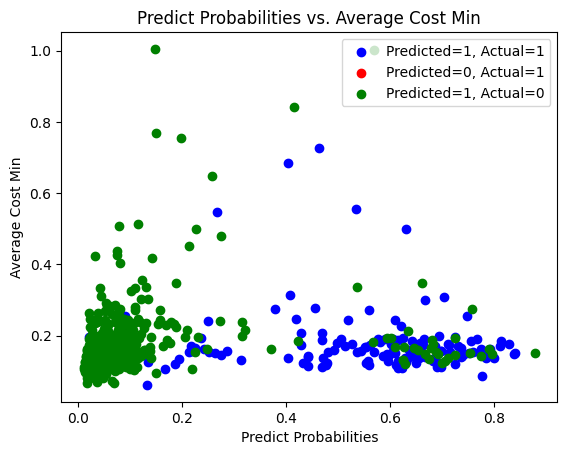

In [330]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

This plot shows that only one churning point with high Average Cost Min is not identified by the model, the other 4 in that area are. The issue is that since there are many many more observations with a low average cost min, the top 20 predicted by the model are more likely to be all of low average cost min.

#### Test Predictions

In [331]:
y_pred_proba_test = best_rf.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [332]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [333]:
df_results.to_csv("Model_Results_random_forest.csv", index = False)

### 2. KNN

#### fitting the model with default hyperparameters

In [393]:
# import necessary functions
from sklearn.neighbors import KNeighborsClassifier

In [394]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [395]:
# Cross validation
knn_cv = cross_val_score(knn, X_train, y_train, cv=skf, scoring = model_score)
knn_cv.mean()

1.4337999000432537

#### hyperparameters tunning

In [399]:
# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(1, 100, 1),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'p': [1, 2],  # Power parameter for the Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
}

# Create RandomizedSearchCV with custom scoring

knn_gs = RandomizedSearchCV(knn, param_grid, cv=skf, scoring=model_score)

knn_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(knn_gs.best_params_)

{'weights': 'uniform', 'p': 1, 'n_neighbors': 51, 'algorithm': 'ball_tree'}


In [400]:
# Create a Random Forest model with the best parameters
best_knn = KNeighborsClassifier(**knn_gs.best_params_)

# Fit the model to the training data
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=51, p=1)

In [401]:
# Cross validation
best_knn_cv = cross_val_score(best_knn, X_train, y_train, cv=skf, scoring = model_score)
best_knn_cv.mean()

1.5068980853850706

#### gap analysis

In [339]:
y_pred_proba = knn.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

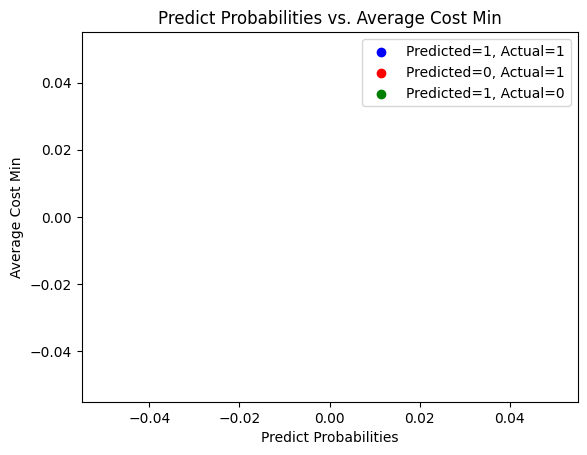

In [340]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### Test Predictions

In [341]:
y_pred_proba_test = knn.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [342]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [343]:
df_results.to_csv("Model_Results_knn.csv", index = False)

### 3. Decision tree

#### fitting and cross validation

In [402]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=random_seed)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [403]:
dt_cv = cross_val_score(dt, X_train, y_train, cv=skf, scoring = model_score)
dt_cv.mean()


1.0750071452261483

In [406]:
# Define the parameter grid
param_grid = {
    'max_depth': np.arange(50, 500, 10),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create RandomizedSearchCV with custom scoring

dt_gs = RandomizedSearchCV(dt, param_grid, cv=skf, scoring=model_score)

# Fit the model
dt_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(dt_gs.best_params_)


{'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 90}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

In [408]:
# Create a Decision Tree model with the best parameters
best_dt = DecisionTreeClassifier(**dt_gs.best_params_)

# Fit the model to the training data
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=90, min_samples_leaf=5, min_samples_split=5)

In [409]:
best_dt_cv = cross_val_score(best_dt, X_train, y_train, cv=5, scoring = model_score)
best_dt_cv.mean()

1.3663656246608884

#### gap analysis

In [ ]:
y_pred_proba = decision_tree.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

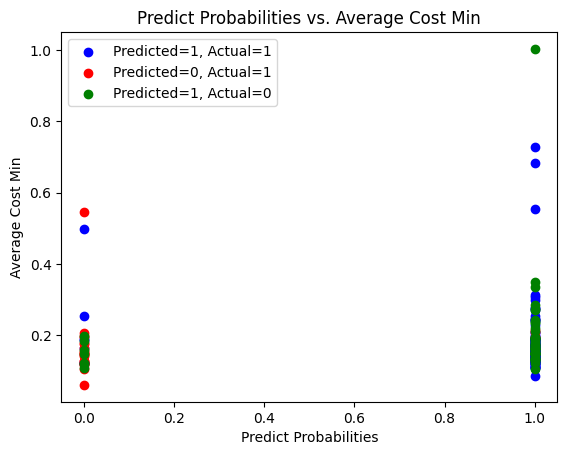

In [ ]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [ ]:
y_pred_proba_test = best_dt.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [ ]:
df_results.to_csv("Model_Results_decision_tree.csv", index = False)

### 4.Logistic regression

#### fitting and cross validation

In [410]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [411]:
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=skf, scoring = model_score)
logreg_cv.mean()

1.3828060640426236

#### hyperparameters tunning

In [413]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty (L1 or L2)
    'C': np.logspace(-4, 4, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300, 400, 500]  # Maximum number of iterations
}

# Create RandomizedSearchCV with custom scoring
logreg_gs = RandomizedSearchCV(logreg, param_grid, cv=skf, scoring=model_score)

# Fit the model
logreg_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(logreg_gs.best_params_)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 500, 'C': 11.288378916846883}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [414]:
# Create a logistic regression model with the best parameters
best_logreg = LogisticRegression(**logreg_gs.best_params_)

# Fit the model to the training data
best_logreg.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=11.288378916846883, max_iter=500, penalty='l1',
                   solver='saga')

In [415]:
best_logreg_cv = cross_val_score(best_logreg, X_train, y_train, cv=skf, scoring = model_score)
best_logreg_cv.mean()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

1.4931998844536694

#### gap analysis

In [ ]:
y_pred_proba = logreg.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

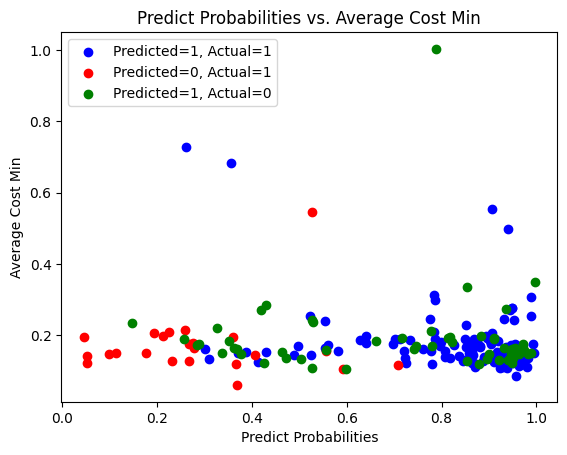

In [ ]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [ ]:
y_pred_proba_test = logreg.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [ ]:
df_results.to_csv("Model_Results_logreg.csv", index = False)

### 5. Neural Networks

#### fitting and cross validation

In [416]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

mlp.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [421]:
mlp_cv = cross_val_score(mlp, X_train, y_train, cv=skf, scoring = model_score)
mlp_cv.mean()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

1.657666942286442

#### hyperparameters tunning

In [417]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],  # Sizes of hidden layers
    'activation': ['logistic', 'tanh', 'relu'],  # Activation function for hidden layers
    'solver': ['adam', 'sgd'],  # Solver for weight optimization
    'alpha': np.logspace(-4, 4, 20),  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule for weight updates
}

# Create RandomizedSearchCV with custom scoring
mlp_gs = RandomizedSearchCV(mlp, param_grid, cv=skf, scoring=model_score)

# Fit the model
mlp_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(mlp_gs.best_params_)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

{'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.03359818286283781, 'activation': 'relu'}


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [419]:
# Create a neural network model with the best parameters
best_mlp = MLPClassifier(**mlp_gs.best_params_)

# Fit the model to the training data
best_mlp.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.03359818286283781, learning_rate='adaptive')

In [420]:
# Cross validation
best_mlp_cv = cross_val_score(best_mlp, X_train, y_train, cv=skf, scoring = model_score)
best_mlp_cv.mean()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

1.5822657779584677

#### gap analysis

In [ ]:
y_pred_proba = best_mlp.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

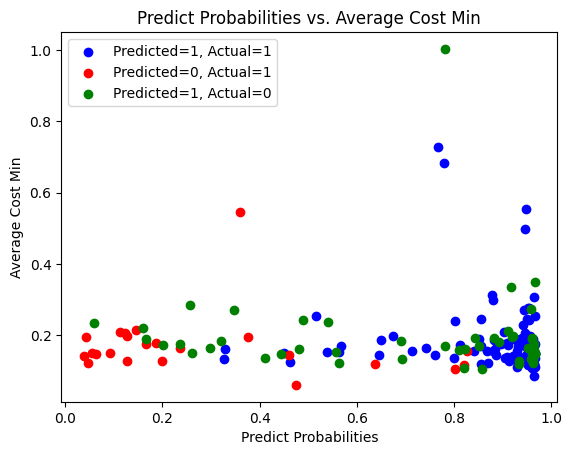

In [ ]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [ ]:
y_pred_proba_test = mlp.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [ ]:
df_results.to_csv("Model_Results_mlp.csv", index = False)

## Ensemble models

### 1. Bagging

#### fitting and cross validation

In [424]:
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline

bag = BaggingClassifier()

bag.fit(X_train, y_train)

BaggingClassifier()

In [425]:
bag_cv = cross_val_score(bag, X_train, y_train, cv=skf, scoring = model_score)
bag_cv.mean()

1.2804975828502347

#### hyperparameters tunning

In [427]:
#hyperparameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 150, 200, 250, 300],  # Number of base estimators
    'max_samples': [0.5, 0.7, 0.9, 1.0],  # Number of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 0.9, 1.0]  # Number of features to draw from X to train each base estimator
}

# Create RandomizedSearchCV with custom scoring
bag_gs = RandomizedSearchCV(bag, param_grid, cv=skf, scoring=model_score)

# Fit the model
bag_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(bag_gs.best_params_)

{'n_estimators': 50, 'max_samples': 0.5, 'max_features': 0.5}


In [428]:
# Create a neural network model with the best parameters
best_bag = BaggingClassifier(**bag_gs.best_params_)

# Fit the model to the training data
best_bag.fit(X_train, y_train)

BaggingClassifier(max_features=0.5, max_samples=0.5, n_estimators=50)

In [429]:
# Cross validation
best_bag_cv = cross_val_score(bag_gs, X_train, y_train, cv=skf, scoring = model_score)
best_bag_cv.mean()

KeyboardInterrupt: 

#### gap analysis

In [ ]:
y_pred_proba = pipeline.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

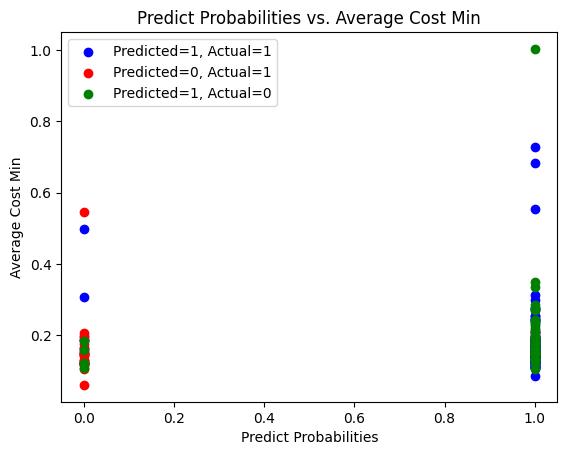

In [ ]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [ ]:
y_pred_proba_test = pipeline.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test

In [ ]:
df_results.to_csv("Model_Results_pipeline.csv", index = False)

### 2. Boosting - Gradient Boosting

#### fitting and cross validation

In [430]:
# install necessary functions
from xgboost import XGBClassifier

In [431]:
cats1 = X_train.select_dtypes(exclude=np.number).columns.tolist()
cats2 = X_val.select_dtypes(exclude=np.number).columns.tolist()
cats3 = X_test.select_dtypes(exclude=np.number).columns.tolist()
for col in cats1:
    X_train[col] = X_train[col].astype('float')
for col in cats2:
    X_val[col] = X_val[col].astype('float')
for col in cats3:
    X_test[col] = X_test[col].astype('float')

In [432]:
# fitting the model
gb = XGBClassifier()
gb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [433]:
gb_cv = cross_val_score(gb, X_train, y_train, cv=skf, scoring = model_score)
gb_cv.mean()

1.4934646017090465

#### hyperparameters tunning

In [434]:
# hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of the tree
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
}

# Create RandomizedSearchCV with custom scoring
gb_gs = RandomizedSearchCV(gb, param_grid, cv=skf, scoring=model_score)

# Fit the model
gb_gs.fit(X_train, y_train)

# Print the best parameters and best score
print(gb_gs.best_params_)

{'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}


In [437]:
# Create a neural network model with the best parameters
best_gb = XGBClassifier(**gb_gs.best_params_)

# Fit the model to the training data
best_gb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [438]:
# Cross validation
best_gb_cv = cross_val_score(gb_gs, X_train, y_train, cv=skf, scoring = model_score)
best_gb_cv.mean()

1.5475535815541595

#### gap analysis

In [ ]:
y_pred_proba = gradient_boosting.predict_proba(X_val)
y_pred_proba = [sublist[1] for sublist in y_pred_proba]

df_results_val = pd.DataFrame()
df_results_val['y_pred'] = y_pred
df_results_val['y_true'] = y_val
df_results_val['predict_proba'] = y_pred_proba
df_results_val['average cost min'] = list(averagecostmin)

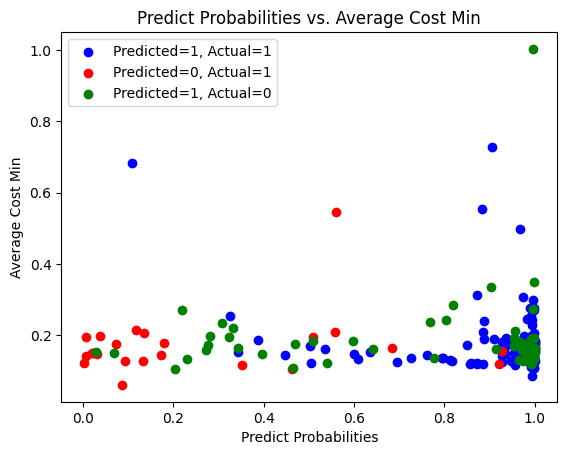

In [ ]:
# Scatter plot for predicted target = 1 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='blue', label='Predicted=1, Actual=1')

# Scatter plot for predicted target = 0 and actual target = 1
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 0) & (df_results_val['y_true'] == 1), 'average cost min'],
            color='red', label='Predicted=0, Actual=1')

# Scatter plot for predicted target = 1 and actual target = 0
plt.scatter(df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'predict_proba'],
            df_results_val.loc[(df_results_val['y_pred'] == 1) & (df_results_val['y_true'] == 0), 'average cost min'],
            color='green', label='Predicted=1, Actual=0')

# Set labels and title
plt.xlabel('Predict Probabilities')
plt.ylabel('Average Cost Min')
plt.title('Predict Probabilities vs. Average Cost Min')

# Add legend
plt.legend()

# Show plot
plt.show()

#### test prediction

In [ ]:
y_pred_proba_test = gradient_boosting.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_Gradient_Boosting.csv", index = False)

## Voting 

In [439]:
## just take 6 best models make the voting 
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier


classifiers = [ ('Random forest', random_forest),('Knn', knn),('decision three', decision_tree),('Logistic Regression', logreg),
               ('K Nearest Neighbours', knn), ('mlp', best_mlp), ('gradient boosting', gradient_boosting), ('bagging', pipeline)] 

# Instantiate a VotingClassifier vc with 'soft' voting
vc = VotingClassifier(estimators=classifiers, voting='soft')

# Fit vc to the training set
vc.fit(X_train, y_train)

# Evaluate the test set predictions
y_pred_proba = vc.predict_proba(X_val)  # Probability estimates for each class
y_pred = vc.predict(X_val)  # Predicted class labels
# Calculate accuracy score using custom scoring function
accuracy = model_score(vc, X_val, y_val)
print('Voting Classifier Accuracy: {:.3f}'.format(accuracy))

NameError: name 'gradient_boosting' is not defined

In [ ]:
y_pred_proba_test = vc.predict_proba(X_test)
y_pred_proba_test = [sublist[1] for sublist in y_pred_proba_test]

In [ ]:
#to make it a CSV
df_results = pd.DataFrame()
df_results["ID"] = idtest
df_results["PRED"] = y_pred_proba_test
df_results.to_csv("Model_Results_Voting.csv", index = False)

### Scores on validation

In [440]:
best_gb_val = cross_val_score(gb_gs, X_val, y_val, cv=skf, scoring = model_score)
best_gb_val.mean()

1.0664522844090403

In [441]:
best_rf_val = cross_val_score(rf_gs, X_val, y_val, cv=skf, scoring = model_score)
best_rf_val.mean()

KeyboardInterrupt: 